In [1]:
library("Matrix")
library(Seurat)
library(DT)
library(dplyr)
library(here)
library(ggplot2)
library(mclust)
library(cowplot)
library(tidyverse)
library(reshape)
library(SingleR)
library(annotate)
library("org.Mm.eg.db")
library(biomaRt)
library(scCustomize)
library(future)
library(ggnewscale)
library(furrr)
library(readxl)
library(STACAS)
library(patchwork)

rank_score_func <- function(df){

df <- df %>% mutate(score = -1*log(p_val_adj+(10^-310))*avg_logFC*(pct.1/(pct.2+10^-300)))

return(df)
}

convertHumanGeneList <- function(x){

require("biomaRt")
human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")

genesV2 = getLDS(attributes = c("hgnc_symbol"), filters = "hgnc_symbol", values = x , mart = human, attributesL = c("mgi_symbol"), martL = mouse, uniqueRows=T)

humanx <- unique(genesV2[, 2])

# Print the first 6 genes found to the screen
print(head(humanx))
return(humanx)
}

library("remotes")
library("fs")

ggtheme <- function() {
  theme(
    axis.text = element_text(size = 10),
    axis.title = element_text(size = 10),
      plot.title = element_text(size = 10),
    text = element_text(size = 10, colour = "black"),
    legend.text = element_text(size = 10),
    legend.key.size =  unit(10, units = "points")
    
  )
}

mid.se <- celldex::MonacoImmuneData();

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject


Attaching package: 'DT'


The following object is masked from 'package:SeuratObject':

    JS


The following object is masked from 'package:Seurat':

    JS



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


here() starts at /auto/brno2/home/vercanie/DIA

Package 'mclust' version 5.4.8
Type 'citation("mclust")' for citing this R package in publica

### Read datasets

In [2]:
plan("multisession")

In [3]:
cd8_full_filt  <- readRDS("data/processed/cd8_full_filt.rds")
cd8_subcluster  <- readRDS("data/processed/cd8_subcluster.rds")
nk_subcluster  <- readRDS("data/processed/nk_subcluster.rds")
unc_subcluster  <- readRDS("data/processed/unc_subcluster.rds")


# Full dataset

## Cluster composition

In [47]:
cd8_full_filt@misc$colors_annotations_l1  <- c("slategrey","#44918b",  "grey77")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



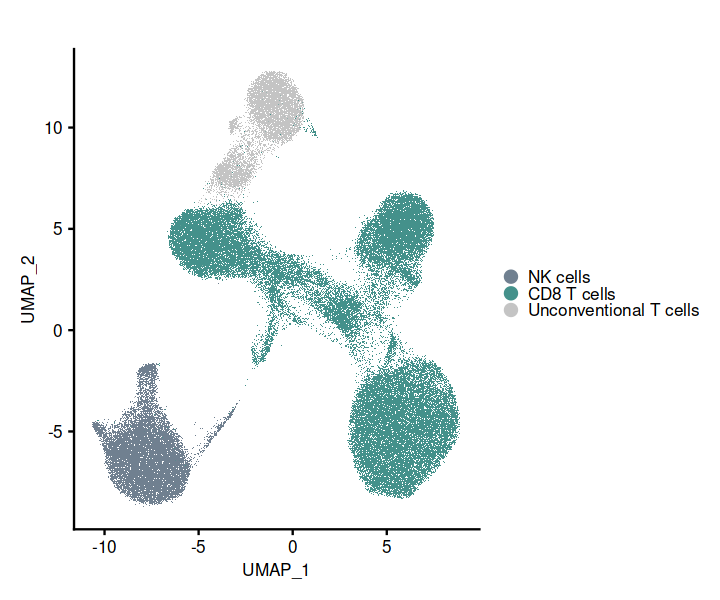

In [48]:
options(repr.plot.width = 6, repr.plot.height = 5)

dimplot1  <- DimPlot(cd8_full_filt, label = F, raster = T, group.by = "annotations_l1",
       cols = cd8_full_filt@misc$colors_annotations_l1) + ggtheme() + ggtitle("")
dimplot1

In [49]:
options(repr.plot.width = 15, repr.plot.height = 5)

seurat_meta_data <- cd8_full_filt@meta.data

# Create grouped dataframe, calculate the frequencies of clusters
df4 <- seurat_meta_data %>% 
  group_by(Sample_ID, annotations_l1) %>% 
  summarise(n = n()) %>% 
  unique() %>% 
  mutate(freq = n / sum(n))  %>% 
dplyr::select(-n)  %>% 
ungroup   %>% 
pivot_wider(names_from = "annotations_l1", values_from = "freq", values_fill = 0)   %>% 
pivot_longer(!Sample_ID, values_to = "freq", names_to = "annotations_l1")
# Control - all sums should be one
# df4 %>% group_by(Sample_ID) %>% summarise(sum = sum(freq))

# As we've lost non-grouping variables, let's join them back
md_to_join <- seurat_meta_data %>% 
  dplyr::select(Sample_ID, Condition, Disease, Sex, Age, Age_group, Patient_ID, Time, Experiment_ID) %>% 
  unique()

df4  <- left_join(df4, md_to_join)

# The final plot

p0  <- df4 %>% 
  ggplot(aes(x = Condition, y = freq)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.7, width = 0.9, aes(fill = Condition)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, shape = 21, stackdir='center', aes(fill = Condition), color = "black") + 
  facet_wrap(~annotations_l1, scales = "free", ncol = 6) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
 ylim(0,NA) +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text.x = element_text(angle = 90))

`summarise()` has grouped output by 'Sample_ID'. You can override using the
`.groups` argument.
Joining with `by = join_by(Sample_ID)`
Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


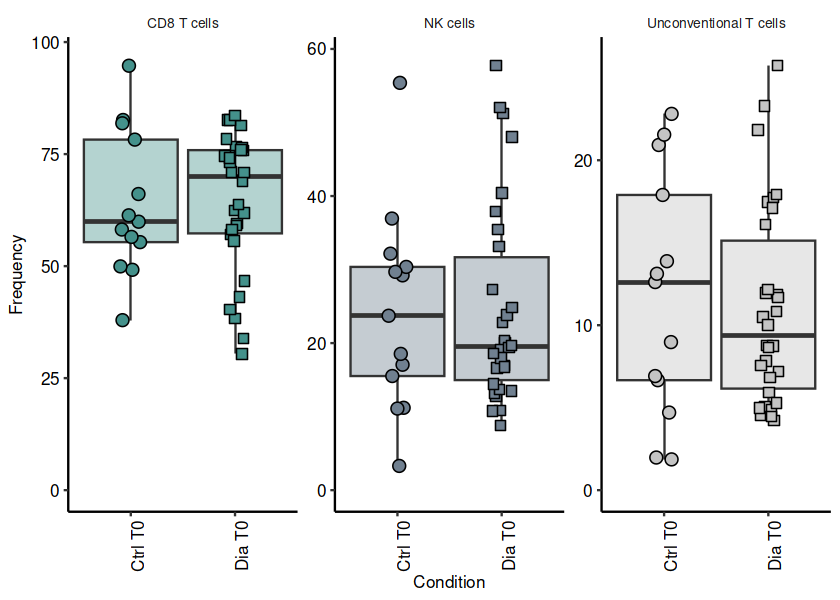

In [50]:
options(repr.plot.width = 7, repr.plot.height = 5)

p1  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = annotations_l1)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = annotations_l1, shape = Condition), color = "black") + 
  facet_wrap(~annotations_l1, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("#44918b", "slategrey", "grey77"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()

p1

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


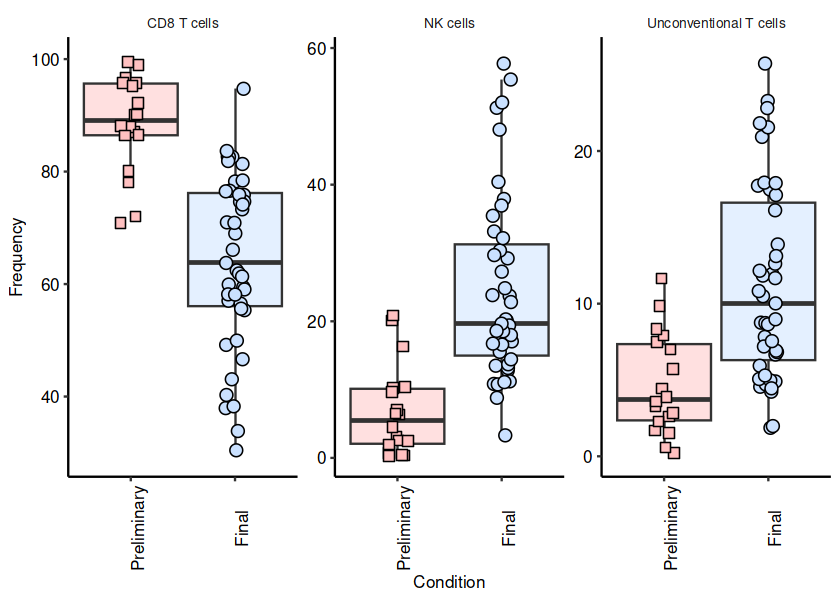

In [51]:
p2  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
  ggplot(aes(x = factor(Exp, levels = c("Preliminary", "Final")), y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
  facet_wrap(~annotations_l1, scales = "free", ncol = 9) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()
p2

In [52]:
layout <- "
AA##
AA##
BBBB
CCCC
"

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


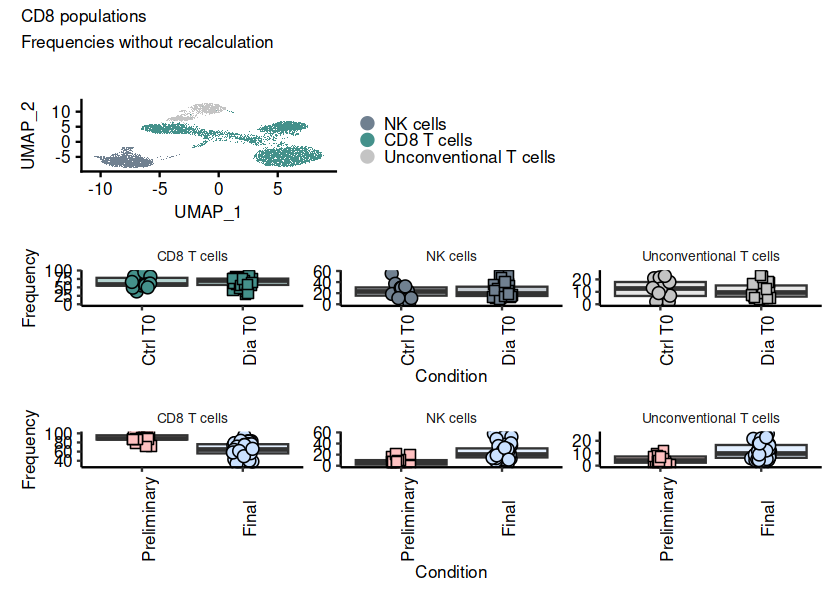

In [53]:
p3  <- dimplot1+p1+p2 + plot_layout(design = layout) + 
plot_annotation(title = "CD8 populations",
                subtitle = "Frequencies without recalculation") & ggtheme()

p3

In [54]:
ggsave(filename="02_Main_populations_CD8.pdf", 
       plot = p3, 
       device = cairo_pdf, 
       width = 210, 
       height = 297, 
       units = "mm")

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


# Coefficient of enrichment for populations in a patient

In [55]:
patients_with_preliminary  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
                                  filter(Exp == "Preliminary")  %>% pull(Patient_ID)  %>% unique

In [56]:
patients_with_preliminary

[1] "201" "202" "105" "110" "104" "106" "108" "111" "204" "208" "209" "210"
[13] "107" "113" "114" "121" "126" "127"

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


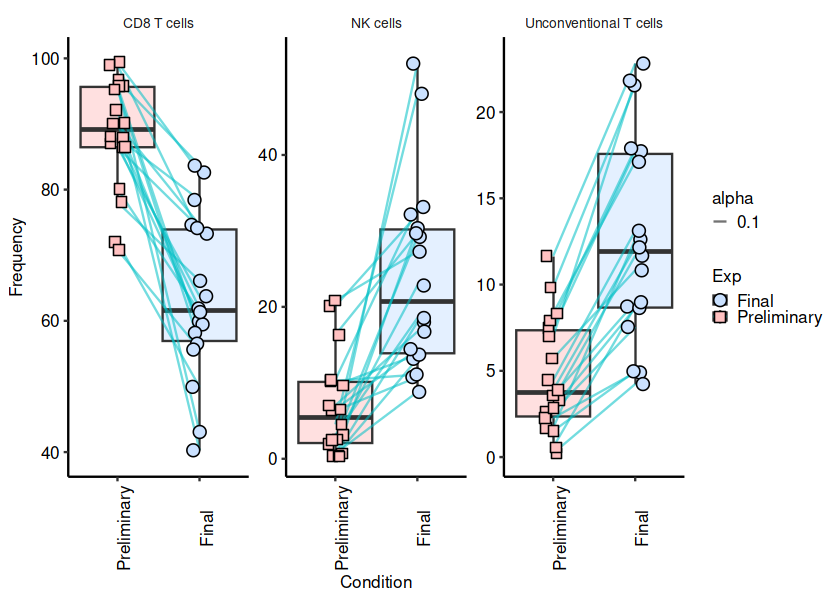

In [57]:
plot_paired  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Patient_ID %in% patients_with_preliminary)  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
  ggplot(aes(x = factor(Exp, levels = c("Preliminary", "Final")), y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_line(aes(group = Patient_ID, color = Exp, alpha = 0.1)) +
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
  facet_wrap(~annotations_l1, scales = "free", ncol = 9) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90))
plot_paired

In [58]:
df5  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Patient_ID %in% patients_with_preliminary)  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
mutate(clusters_change = paste0(Exp, annotations_l1))  %>% 
dplyr::select(Patient_ID, clusters_change, freq)  %>% 
pivot_wider(names_from = "clusters_change", values_from = freq, values_fill = 0) 

df5

Patient_ID,PreliminaryNK cells,PreliminaryCD8 T cells,PreliminaryUnconventional T cells,FinalNK cells,FinalCD8 T cells,FinalUnconventional T cells
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201,0.031212485,0.8703481,0.098439376,0.18534483,0.5991379,0.21551724
202,0.025270758,0.9578821,0.016847172,0.29212532,0.5817104,0.12616427
105,0.003314917,0.9944751,0.002209945,0.13161376,0.8260582,0.04232804
110,0.006825939,0.9670080,0.026166098,0.08801341,0.8365465,0.07544007
104,0.019417476,0.9579288,0.022653722,0.52030651,0.4306513,0.04904215
106,0.004550626,0.9897611,0.005688282,0.17983446,0.7328819,0.08728367
108,0.045287638,0.9216646,0.033047736,0.48054755,0.4027378,0.11671470
111,0.024564995,0.9007165,0.074718526,0.22813990,0.5945946,0.17726550
204,0.003072197,0.9523810,0.044546851,0.30363036,0.5651815,0.13118812


In [59]:
df_all = df5  %>% dplyr::select(Patient_ID)

for(i in 2:(1+((ncol(df5)-1)/2))){
    df = df5  %>% dplyr::select(i,i+3)
    colnames(df) = c("x","y")
    df = df  %>% mutate(z = round(x, digits = 4)/(round(y, digits = 4)+0.00001))
    df_all = cbind(df_all, df$z)
    colnames(df_all)[i]  <- str_replace(colnames(df5)[i],pattern = "Preliminary", "Final ")
}

df_all

Patient_ID,Final NK cells,Final CD8 T cells,Final Unconventional T cells
<chr>,<dbl>,<dbl>,<dbl>
201,0.16836652,1.452655,0.45659134
202,0.08661121,1.646697,0.13311148
105,0.02507408,1.203835,0.05199716
110,0.07726395,1.155993,0.34743403
104,0.03728546,2.224002,0.46317078
106,0.02558256,1.350507,0.06528462
108,0.09427483,2.288744,0.28275212
111,0.10784271,1.514774,0.42129604
204,0.01021047,1.685037,0.33915098


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


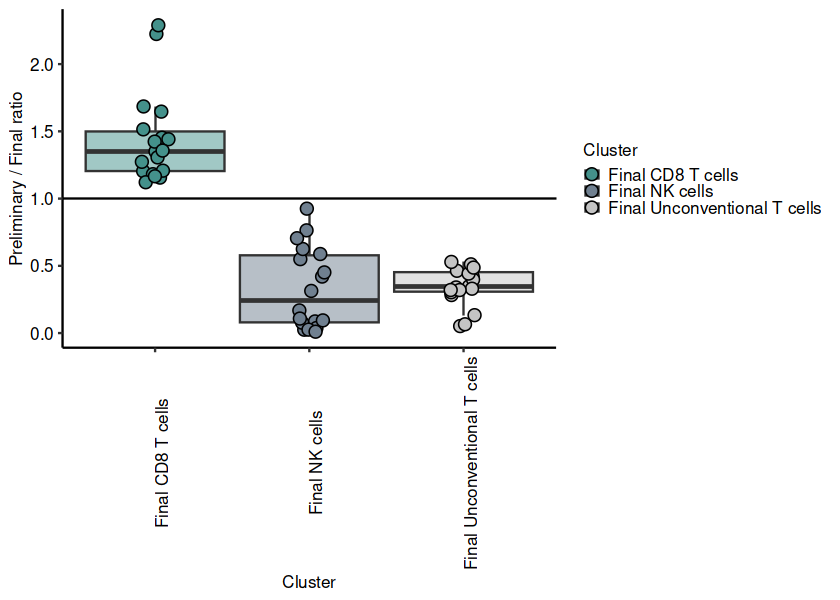

In [60]:
plot_cluster_correction  <-  df_all %>% pivot_longer(!Patient_ID, names_to = "Cluster", values_to = "Prelim_to_Final_ratio", values_drop_na = T)  %>% 
ggplot(aes(x = Cluster, y = Prelim_to_Final_ratio)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Cluster)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = Cluster), shape = 21) + 
scale_fill_manual(values = cd8_full_filt@misc$colors_annotations_l1[c(2,1,3)]) +
  geom_hline(yintercept = 1) +
  ylab("Preliminary / Final ratio") +
  xlab("Cluster") +
  theme_classic() +
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90))

plot_cluster_correction

### Corrected cell frequencies

In [61]:
### V1

In [62]:
coef  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Patient_ID %in% patients_with_preliminary)  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>%
group_by(annotations_l1, Exp)  %>% 
summarize(med = median(freq))  %>% 
pivot_wider(names_from = "Exp", values_from = "med")  %>% 
mutate(coefficient = round(Preliminary, digits = 4)/(round(Final, digits = 4)+0.00001))
coef

`summarise()` has grouped output by 'annotations_l1'. You can override using
the `.groups` argument.


annotations_l1,Final,Preliminary,coefficient
<chr>,<dbl>,<dbl>,<dbl>
CD8 T cells,0.6160666,0.89086815,1.4460080
NK cells,0.2067424,0.05426775,0.2626869
Unconventional T cells,0.1191332,0.03731519,0.3131559


In [63]:
df5  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
left_join(dplyr::select(coef, annotations_l1, coefficient))  %>% 
mutate(freq_corrected = freq*coefficient)

Joining with `by = join_by(annotations_l1)`


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


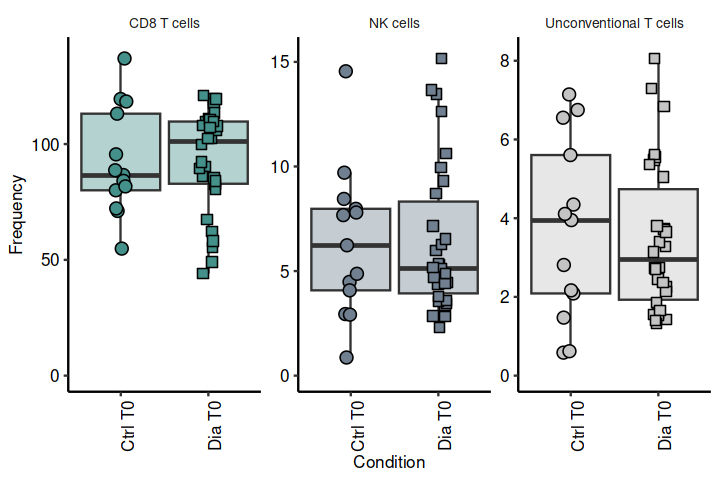

In [64]:
options(repr.plot.width = 6, repr.plot.height = 4)

p5  <- df5 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition, y = freq_corrected*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = annotations_l1)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = annotations_l1, shape = Condition), color = "black") + 
  facet_wrap(~annotations_l1, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("#44918b", "slategrey", "grey77"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()

p5

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


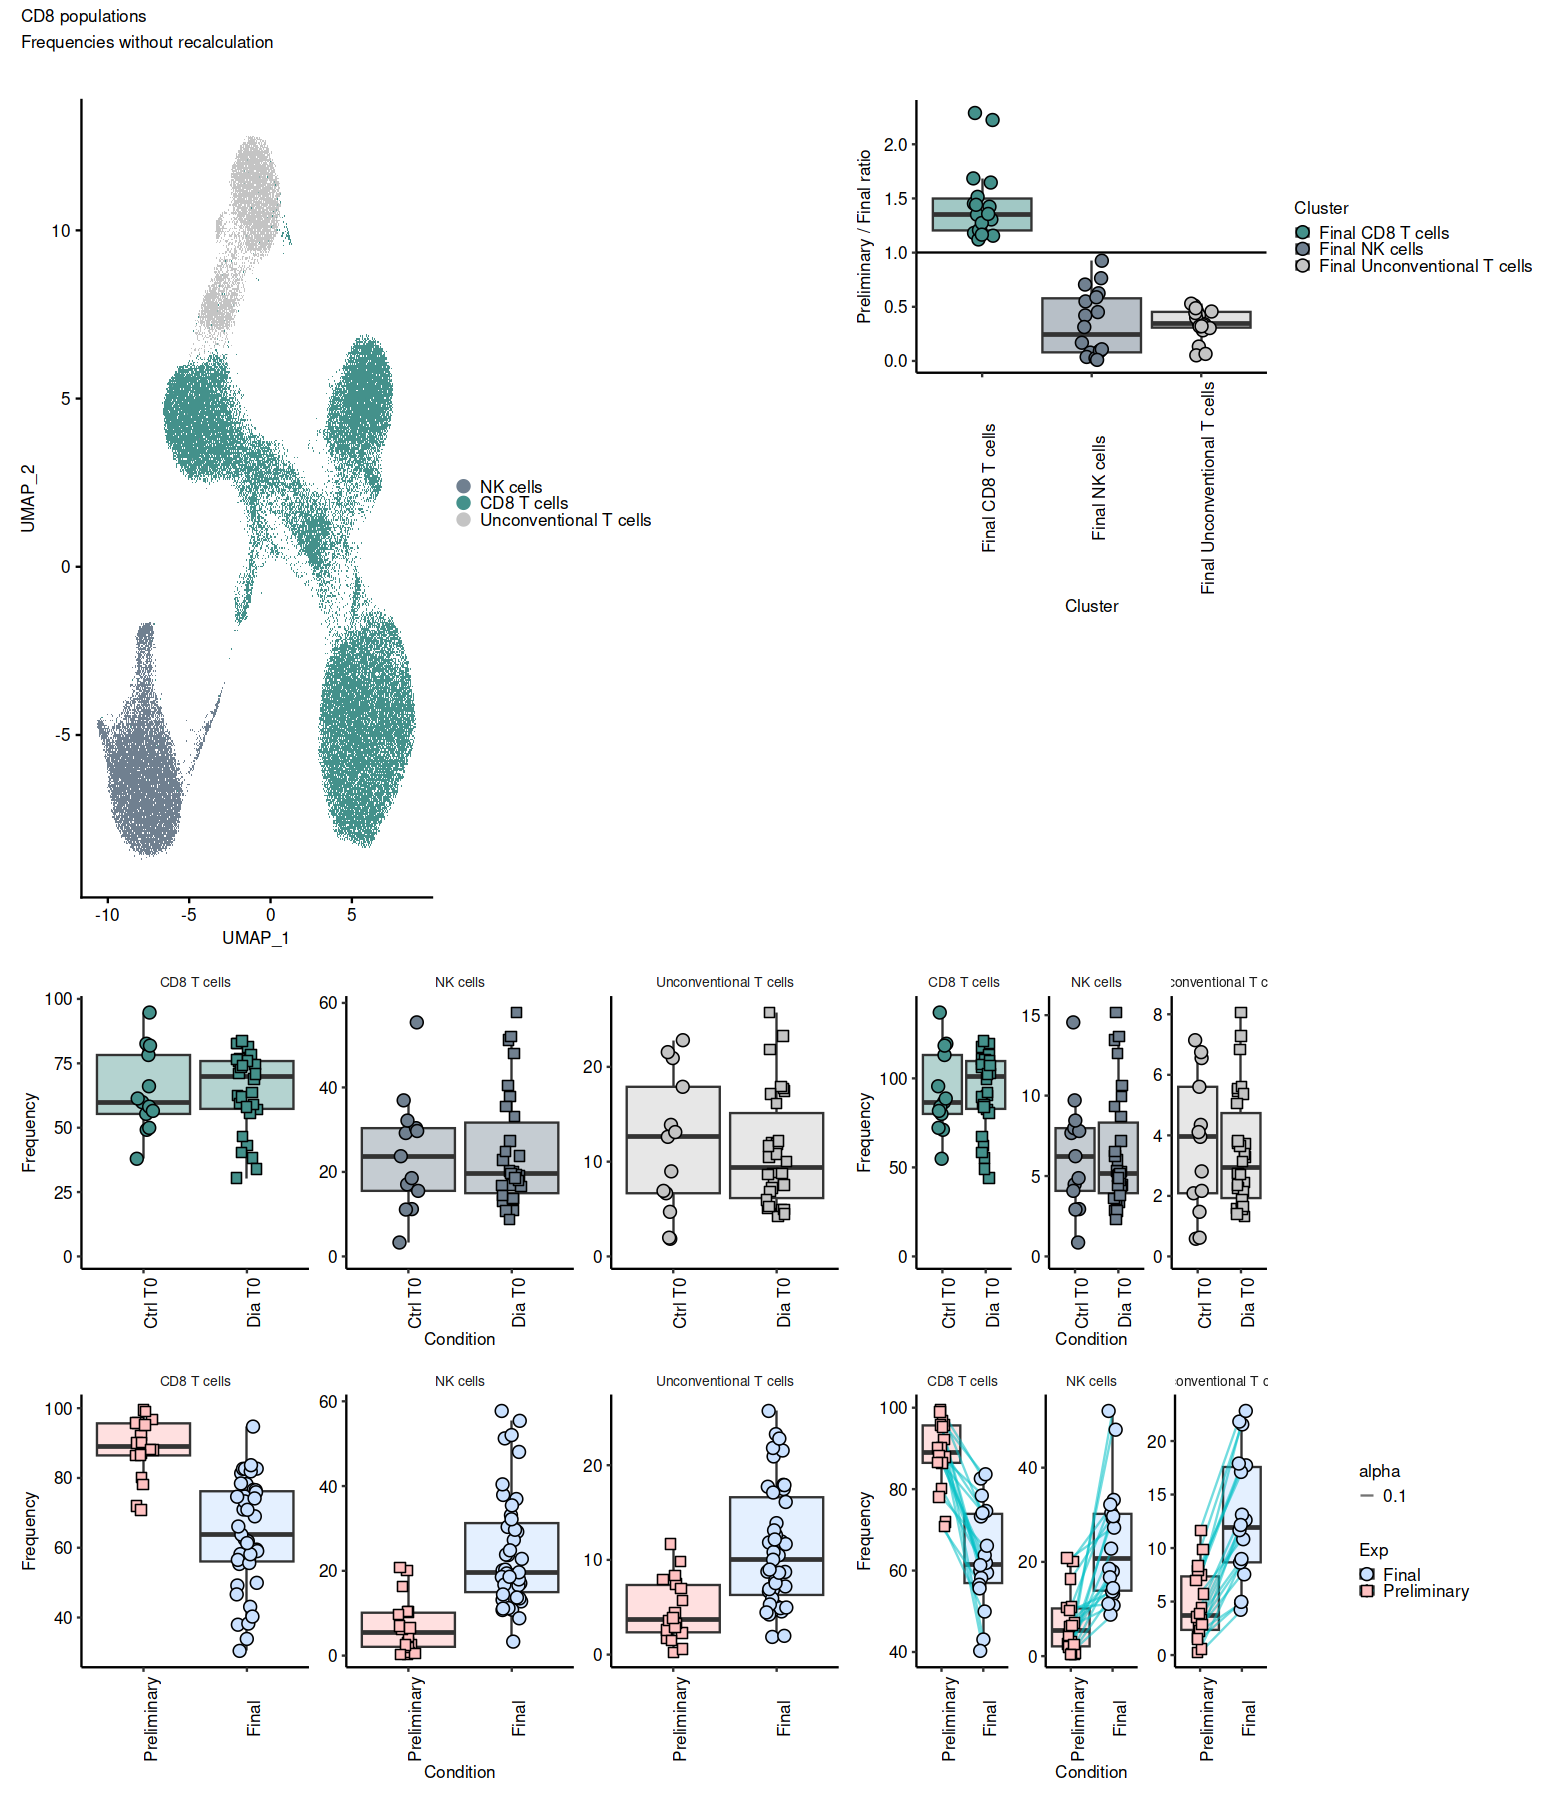

In [100]:
options(repr.plot.width = 13, repr.plot.height = 15)

layout <- "
AA#BB
AA###
CCCDD
EEEFF
"

p4 <- dimplot1 + plot_cluster_correction + p1 + p5 + p2 + plot_paired + plot_layout(design = layout) + 
plot_annotation(title = "CD8 populations",
                subtitle = "Frequencies without recalculation") & ggtheme()

p4

In [101]:
ggsave(filename="02_Main_populations_CD8.pdf", 
       plot = p4, 
       device = cairo_pdf, 
       width = 210, 
       height = 297, 
       units = "mm")

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


In [89]:
### V2

sort ratios in these patients

# CD8 subcluster 

## Cluster composition

In [27]:
cd8_subcluster@misc$cols_annotations_l2  <- c(
     "#6FC4AD", # Tcm2 
     "#92c0df", #Naive
     "#24693d", # TEM ISAGhi
     "#75bc69",  # Tem
     "#b3e0a6" , # Tcm1
     "#88aa00" , # Proliferating
     "#499894", # Temra 
     "#4878a6")

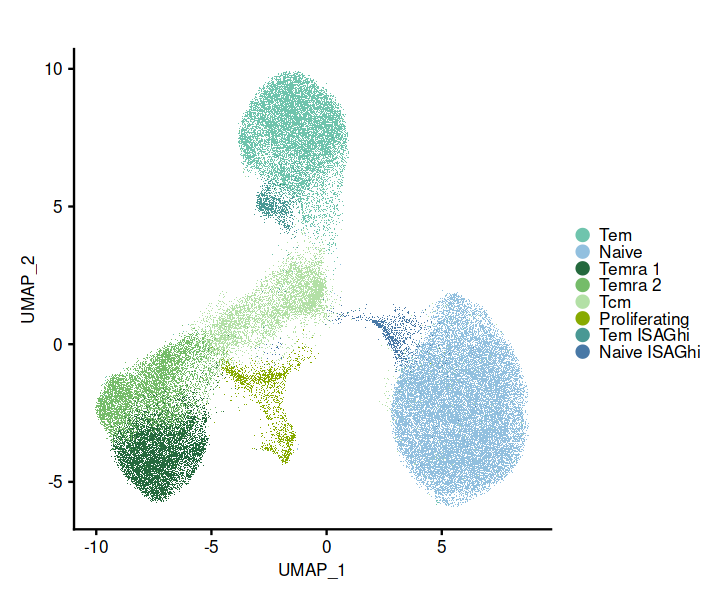

In [28]:
options(repr.plot.width = 6, repr.plot.height = 5)

dimplot1  <- DimPlot(cd8_subcluster, label = F, raster = T, group.by = "annotations_l2",
       cols = cd8_subcluster@misc$cols_annotations_l2) + ggtheme() + ggtitle("")
dimplot1

In [29]:
options(repr.plot.width = 15, repr.plot.height = 5)

seurat_meta_data <- cd8_subcluster@meta.data

# Create grouped dataframe, calculate the frequencies of clusters
df4 <- seurat_meta_data %>% 
  group_by(Sample_ID, annotations_l2) %>% 
  summarise(n = n()) %>% 
  unique() %>% 
  mutate(freq = n / sum(n))  %>% 
dplyr::select(-n)  %>% 
ungroup   %>% 
pivot_wider(names_from = "annotations_l2", values_from = "freq", values_fill = 0)   %>% 
pivot_longer(!Sample_ID, values_to = "freq", names_to = "annotations_l2")
# Control - all sums should be one
# df4 %>% group_by(Sample_ID) %>% summarise(sum = sum(freq))

# As we've lost non-grouping variables, let's join them back
md_to_join <- seurat_meta_data %>% 
  dplyr::select(Sample_ID, Condition, Disease, Sex, Age, Age_group, Patient_ID, Time, Experiment_ID) %>% 
  unique()

df4  <- left_join(df4, md_to_join)

# The final plot

p0  <- df4 %>% 
  ggplot(aes(x = Condition, y = freq)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.7, width = 0.9, aes(fill = Condition)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, shape = 21, stackdir='center', aes(fill = Condition), color = "black") + 
  facet_wrap(~annotations_l2, scales = "free", ncol = 6) +
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
 ylim(0,NA) +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text.x = element_text(angle = 90))

`summarise()` has grouped output by 'Sample_ID'. You can override using the
`.groups` argument.
Joining with `by = join_by(Sample_ID)`
Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


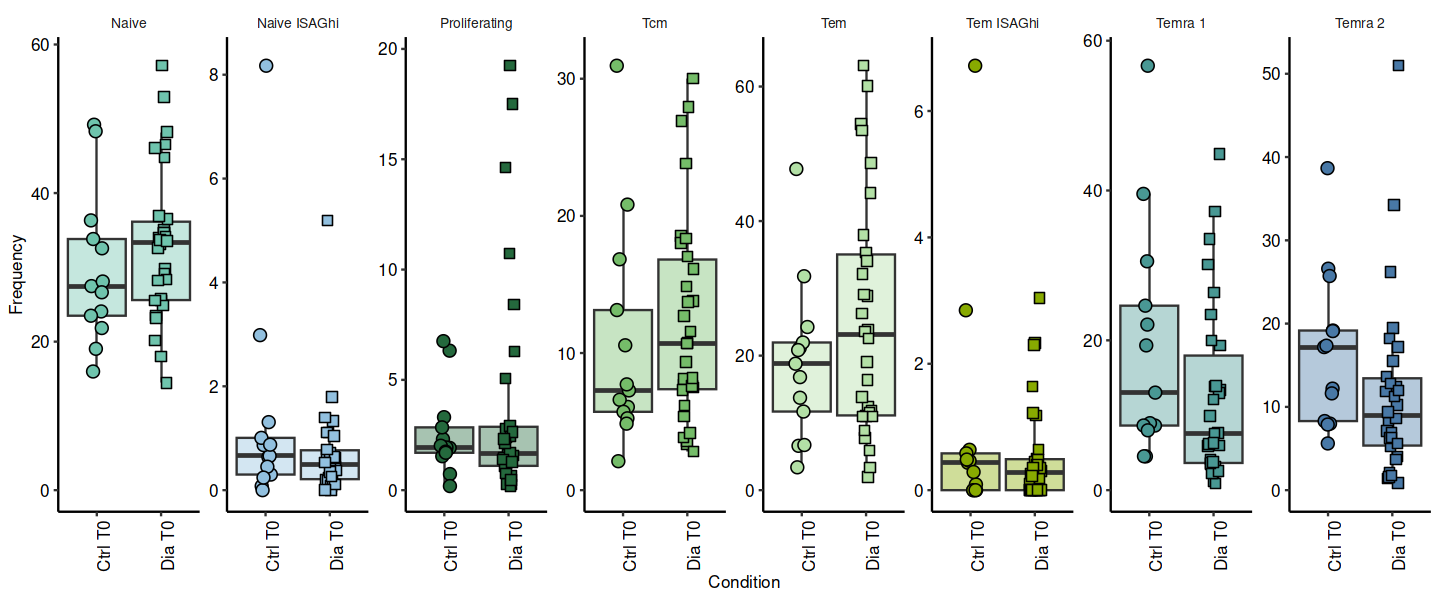

In [30]:
options(repr.plot.width = 12, repr.plot.height = 5)

p1  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition, y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = annotations_l2)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = annotations_l2, shape = Condition), color = "black") + 
  facet_wrap(~annotations_l2, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = cd8_subcluster@misc$cols_annotations_l2)+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()

p1

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


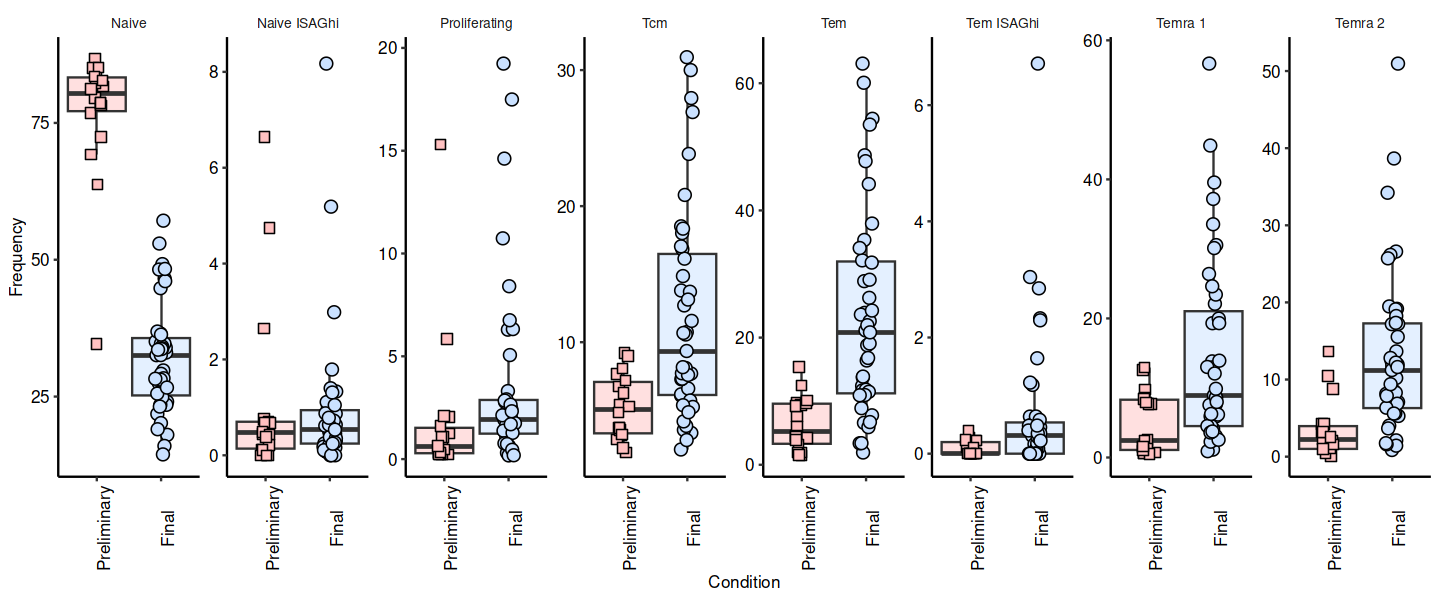

In [31]:
p2  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
  ggplot(aes(x = factor(Exp, levels = c("Preliminary", "Final")), y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
  facet_wrap(~annotations_l2, scales = "free", ncol = 9) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()
p2

In [32]:
layout <- "
AA##
AA##
BBBB
CCCC
"

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


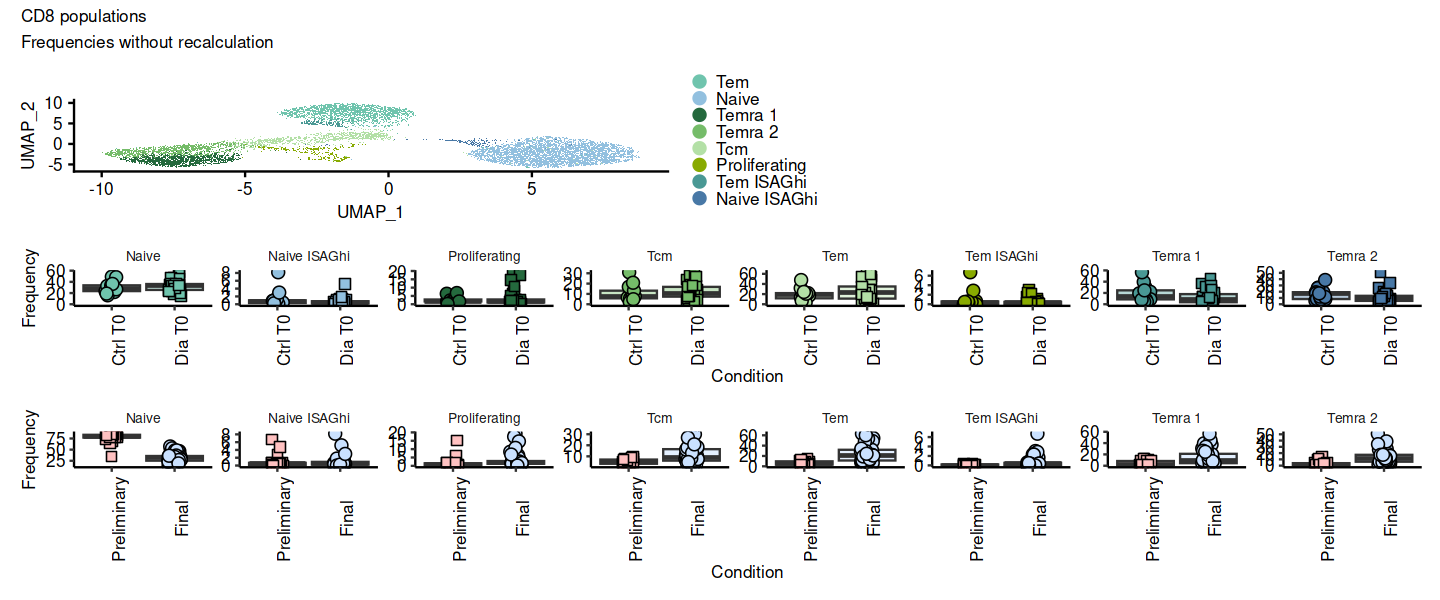

In [33]:
p3  <- dimplot1+p1+p2 + plot_layout(design = layout) + 
plot_annotation(title = "CD8 populations",
                subtitle = "Frequencies without recalculation") & ggtheme()

p3

In [34]:
ggsave(filename="02_CD8subcluster_CD8.pdf", 
       plot = p3, 
       device = cairo_pdf, 
       width = 210, 
       height = 297, 
       units = "mm")

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


# Coefficient of enrichment for populations in a patient

In [35]:
patients_with_preliminary  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
                                  filter(Exp == "Preliminary")  %>% pull(Patient_ID)  %>% unique

In [36]:
patients_with_preliminary

[1] "201" "202" "105" "110" "104" "106" "108" "111" "204" "208" "209" "210"
[13] "107" "113" "114" "121" "126" "127"

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


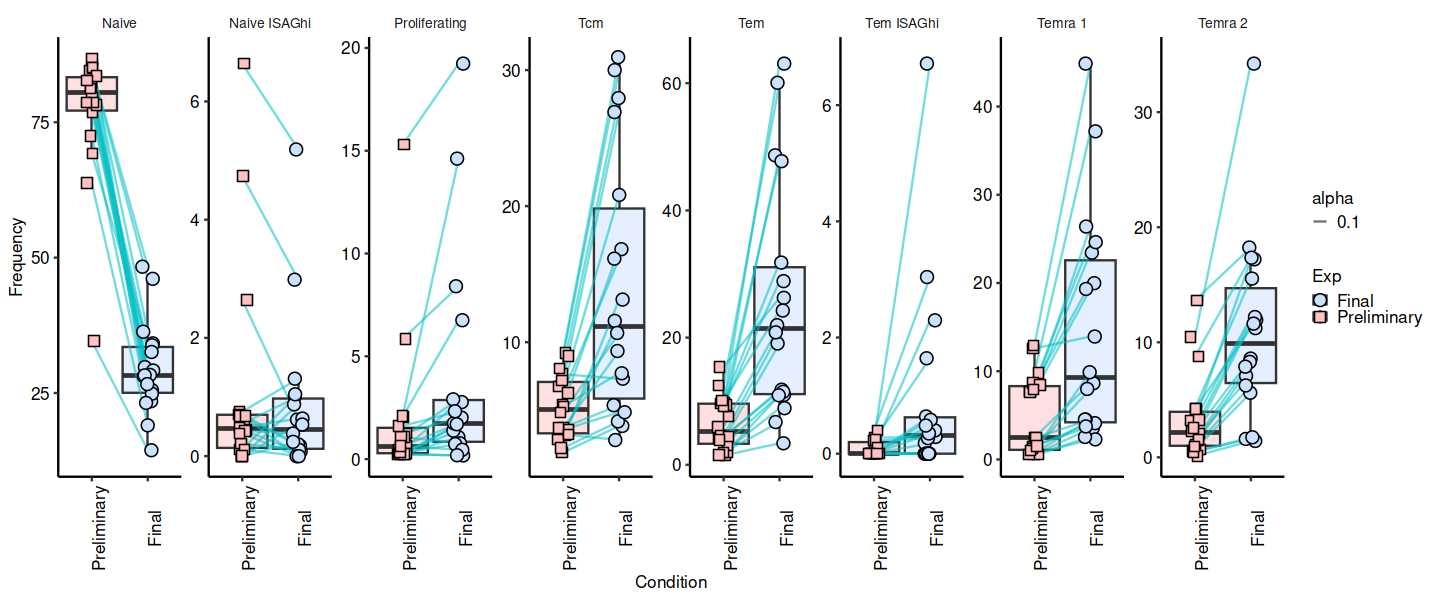

In [37]:
plot_paired  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Patient_ID %in% patients_with_preliminary)  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
  ggplot(aes(x = factor(Exp, levels = c("Preliminary", "Final")), y = freq*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_line(aes(group = Patient_ID, color = Exp, alpha = 0.1)) +
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
  facet_wrap(~annotations_l2, scales = "free", ncol = 9) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90))
plot_paired

In [38]:
df5  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Patient_ID %in% patients_with_preliminary)  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
mutate(clusters_change = paste0(Exp, annotations_l2))  %>% 
dplyr::select(Patient_ID, clusters_change, freq)  %>% 
pivot_wider(names_from = "clusters_change", values_from = freq, values_fill = 0) 

df5

Patient_ID,PreliminaryTem,PreliminaryNaive,PreliminaryTemra 1,PreliminaryTemra 2,PreliminaryTcm,PreliminaryProliferating,PreliminaryTem ISAGhi,PreliminaryNaive ISAGhi,FinalTem,FinalNaive,FinalTemra 1,FinalTemra 2,FinalTcm,FinalProliferating,FinalTem ISAGhi,FinalNaive ISAGhi
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201,0.09793103,0.7958621,0.024827586,0.006896552,0.05379310,0.012413793,0.002758621,0.005517241,0.31798561,0.3381295,0.08633094,0.05611511,0.16834532,0.020143885,0.002877698,0.0100719424
202,0.09422111,0.8165829,0.007537688,0.015075377,0.05276382,0.006281407,0.000000000,0.007537688,0.47743814,0.2809316,0.04512373,0.08296943,0.07714702,0.017467249,0.005822416,0.0131004367
105,0.09666667,0.8666667,0.005555556,0.005555556,0.01888889,0.002222222,0.000000000,0.004444444,0.63090472,0.2554043,0.03522818,0.01601281,0.03843074,0.016813451,0.006405124,0.0008006405
110,0.15411765,0.3458824,0.125882353,0.136470588,0.07647059,0.152941176,0.001176471,0.007058824,0.26252505,0.1442886,0.13927856,0.18236473,0.07314629,0.192384770,0.004008016,0.0020040080
104,0.01463964,0.8457207,0.097972973,0.001126126,0.03153153,0.002252252,0.000000000,0.006756757,0.03380783,0.4608541,0.37188612,0.01423488,0.11565836,0.001779359,0.000000000,0.0017793594
106,0.07586207,0.8229885,0.014942529,0.004597701,0.04827586,0.004597701,0.002298851,0.026436782,0.48665298,0.2977413,0.04106776,0.01745380,0.10677618,0.027720739,0.016427105,0.0061601643
108,0.04249668,0.6918991,0.077025232,0.022576361,0.03718459,0.058432935,0.003984064,0.066401062,0.11806798,0.3416816,0.23434705,0.08586762,0.05366726,0.084078712,0.030411449,0.0518783542
111,0.09204545,0.7681818,0.005681818,0.042045455,0.08068182,0.002272727,0.002272727,0.006818182,0.28877005,0.2834225,0.02272727,0.11229947,0.27941176,0.010695187,0.002673797,0.0000000000
204,0.01935484,0.8500000,0.024193548,0.011290323,0.09193548,0.003225806,0.000000000,0.000000000,0.06715328,0.4832117,0.04525547,0.07883212,0.30948905,0.007299270,0.000000000,0.0087591241


In [39]:
df_all = df5  %>% dplyr::select(Patient_ID)

for(i in 2:(1+((ncol(df5)-1)/2))){
    df = df5  %>% dplyr::select(i,i+3)
    colnames(df) = c("x","y")
    df = df  %>% mutate(z = round(x, digits = 4)/(round(y, digits = 4)+0.00001))
    df_all = cbind(df_all, df$z)
    colnames(df_all)[i]  <- str_replace(colnames(df5)[i],pattern = "Preliminary", "Final ")
}

df_all

Patient_ID,Final Tem,Final Naive,Final Temra 1,Final Temra 2,Final Tcm,Final Proliferating,Final Tem ISAGhi,Final Naive ISAGhi
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201,14.1678726,14.790931,1.9983884,2.455516,9.7640653,0.038992485,0.008281329,0.063723786
202,6.2342819,15.462980,1.1885895,1510.000000,7.0306258,0.013196205,0.000000000,0.166260253
105,17.2370766,45.832893,2.5339367,560.000000,4.2857143,0.003487027,0.000000000,0.124964499
110,1.1288550,4.520978,0.8233601,112.809917,10.7594937,0.582454002,0.008315432,0.050965473
104,13.1531532,26.839099,42.4242424,110.000000,4.6255507,0.068027211,0.000000000,0.018283993
106,16.4642082,17.035810,3.2321041,1.991342,1.8288527,0.009451213,0.007725639,0.642179518
108,1.8796992,18.594464,1.3182674,5.635910,0.5601566,0.494454322,0.011705832,0.283385259
111,2.1899548,9.518028,2.4675325,18.181818,11.8502203,0.007963713,0.008115451,0.299427565
204,1.7152962,9.248178,7.5389408,1130.000000,9190.0000000,0.047611963,0.000000000,0.000000000


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Warning message:
"Removed 14 rows containing non-finite values (`stat_boxplot()`)."
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


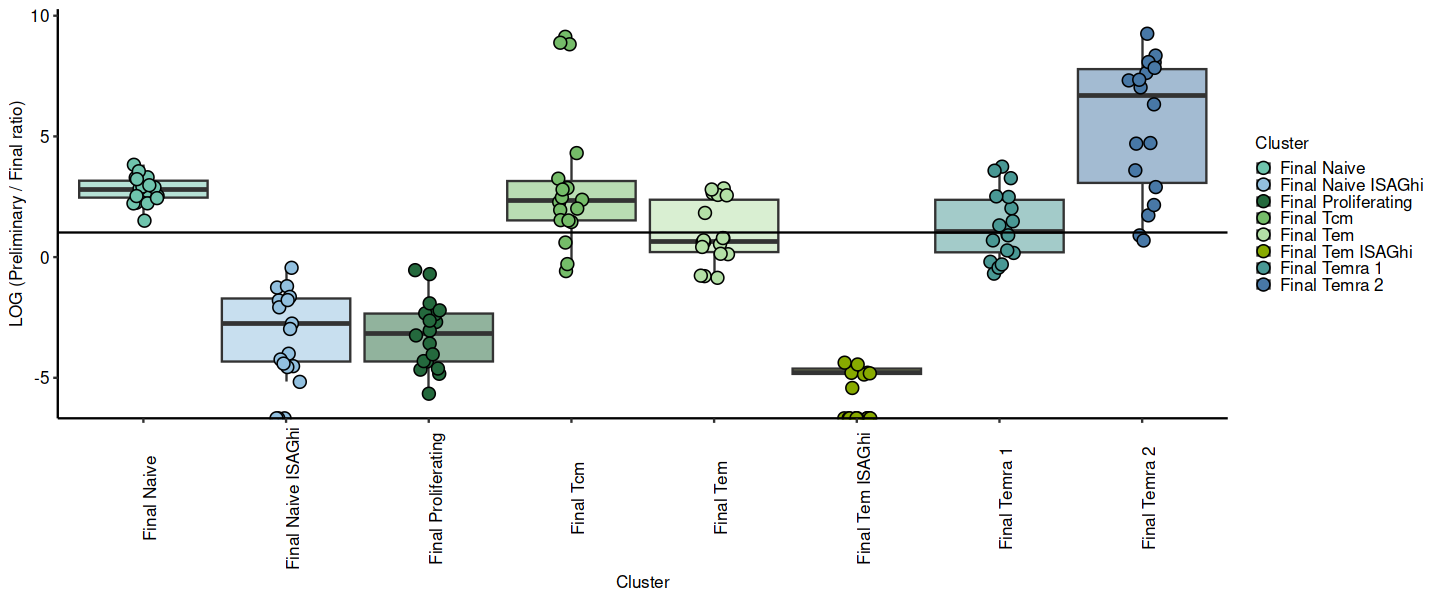

In [40]:
plot_cluster_correction  <-  df_all %>% pivot_longer(!Patient_ID, names_to = "Cluster", values_to = "Prelim_to_Final_ratio", values_drop_na = T)  %>% 
ggplot(aes(x = Cluster, y = log(Prelim_to_Final_ratio))) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.5, width = 0.9, aes(fill = Cluster)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = Cluster), shape = 21) + 
scale_fill_manual(values = cd8_subcluster@misc$cols_annotations_l2) +
  geom_hline(yintercept = 1) +
  ylab("LOG (Preliminary / Final ratio)") +
  xlab("Cluster") +
  theme_classic() +
ggtheme() +
  theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90))

plot_cluster_correction

### Corrected cell frequencies

In [41]:
### V1

In [42]:
coef  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Patient_ID %in% patients_with_preliminary)  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>%
group_by(annotations_l2, Exp)  %>% 
summarize(med = median(freq))  %>% 
pivot_wider(names_from = "Exp", values_from = "med")  %>% 
mutate(coefficient = round(Preliminary, digits = 4)/(round(Final, digits = 4)+0.00001))
coef

`summarise()` has grouped output by 'annotations_l2'. You can override using
the `.groups` argument.


annotations_l2,Final,Preliminary,coefficient
<chr>,<dbl>,<dbl>,<dbl>
Naive,0.282990300,0.804147540,2.8412424
Naive ISAGhi,0.004587062,0.004651765,1.0195228
Proliferating,0.017208201,0.006337634,0.3660662
Tcm,0.111217272,0.050519841,0.4540959
Tem,0.213872320,0.052444295,0.2449628
Tem ISAGhi,0.003183035,0.000000000,0.0000000
Temra 1,0.092584072,0.024510567,0.2645503
Temra 2,0.099083543,0.021604549,0.2179397


In [43]:
df5  <- df4 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0"))  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
left_join(dplyr::select(coef, annotations_l2, coefficient))  %>% 
mutate(freq_corrected = freq*coefficient)

Joining with `by = join_by(annotations_l2)`


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


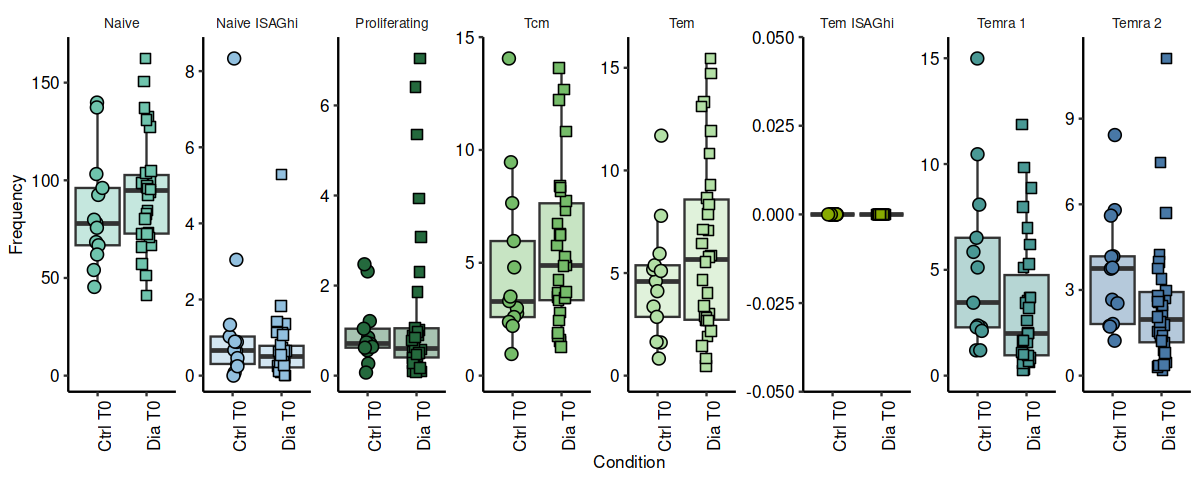

In [44]:
options(repr.plot.width = 10, repr.plot.height = 4)

p5  <- df5 %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
  ggplot(aes(x = Condition, y = freq_corrected*100)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = annotations_l2)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = annotations_l2, shape = Condition), color = "black") + 
  facet_wrap(~annotations_l2, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = cd8_subcluster@misc$cols_annotations_l2)+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 90)) + NoLegend()

p5

Warning message:
"Removed 14 rows containing non-finite values (`stat_boxplot()`)."
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


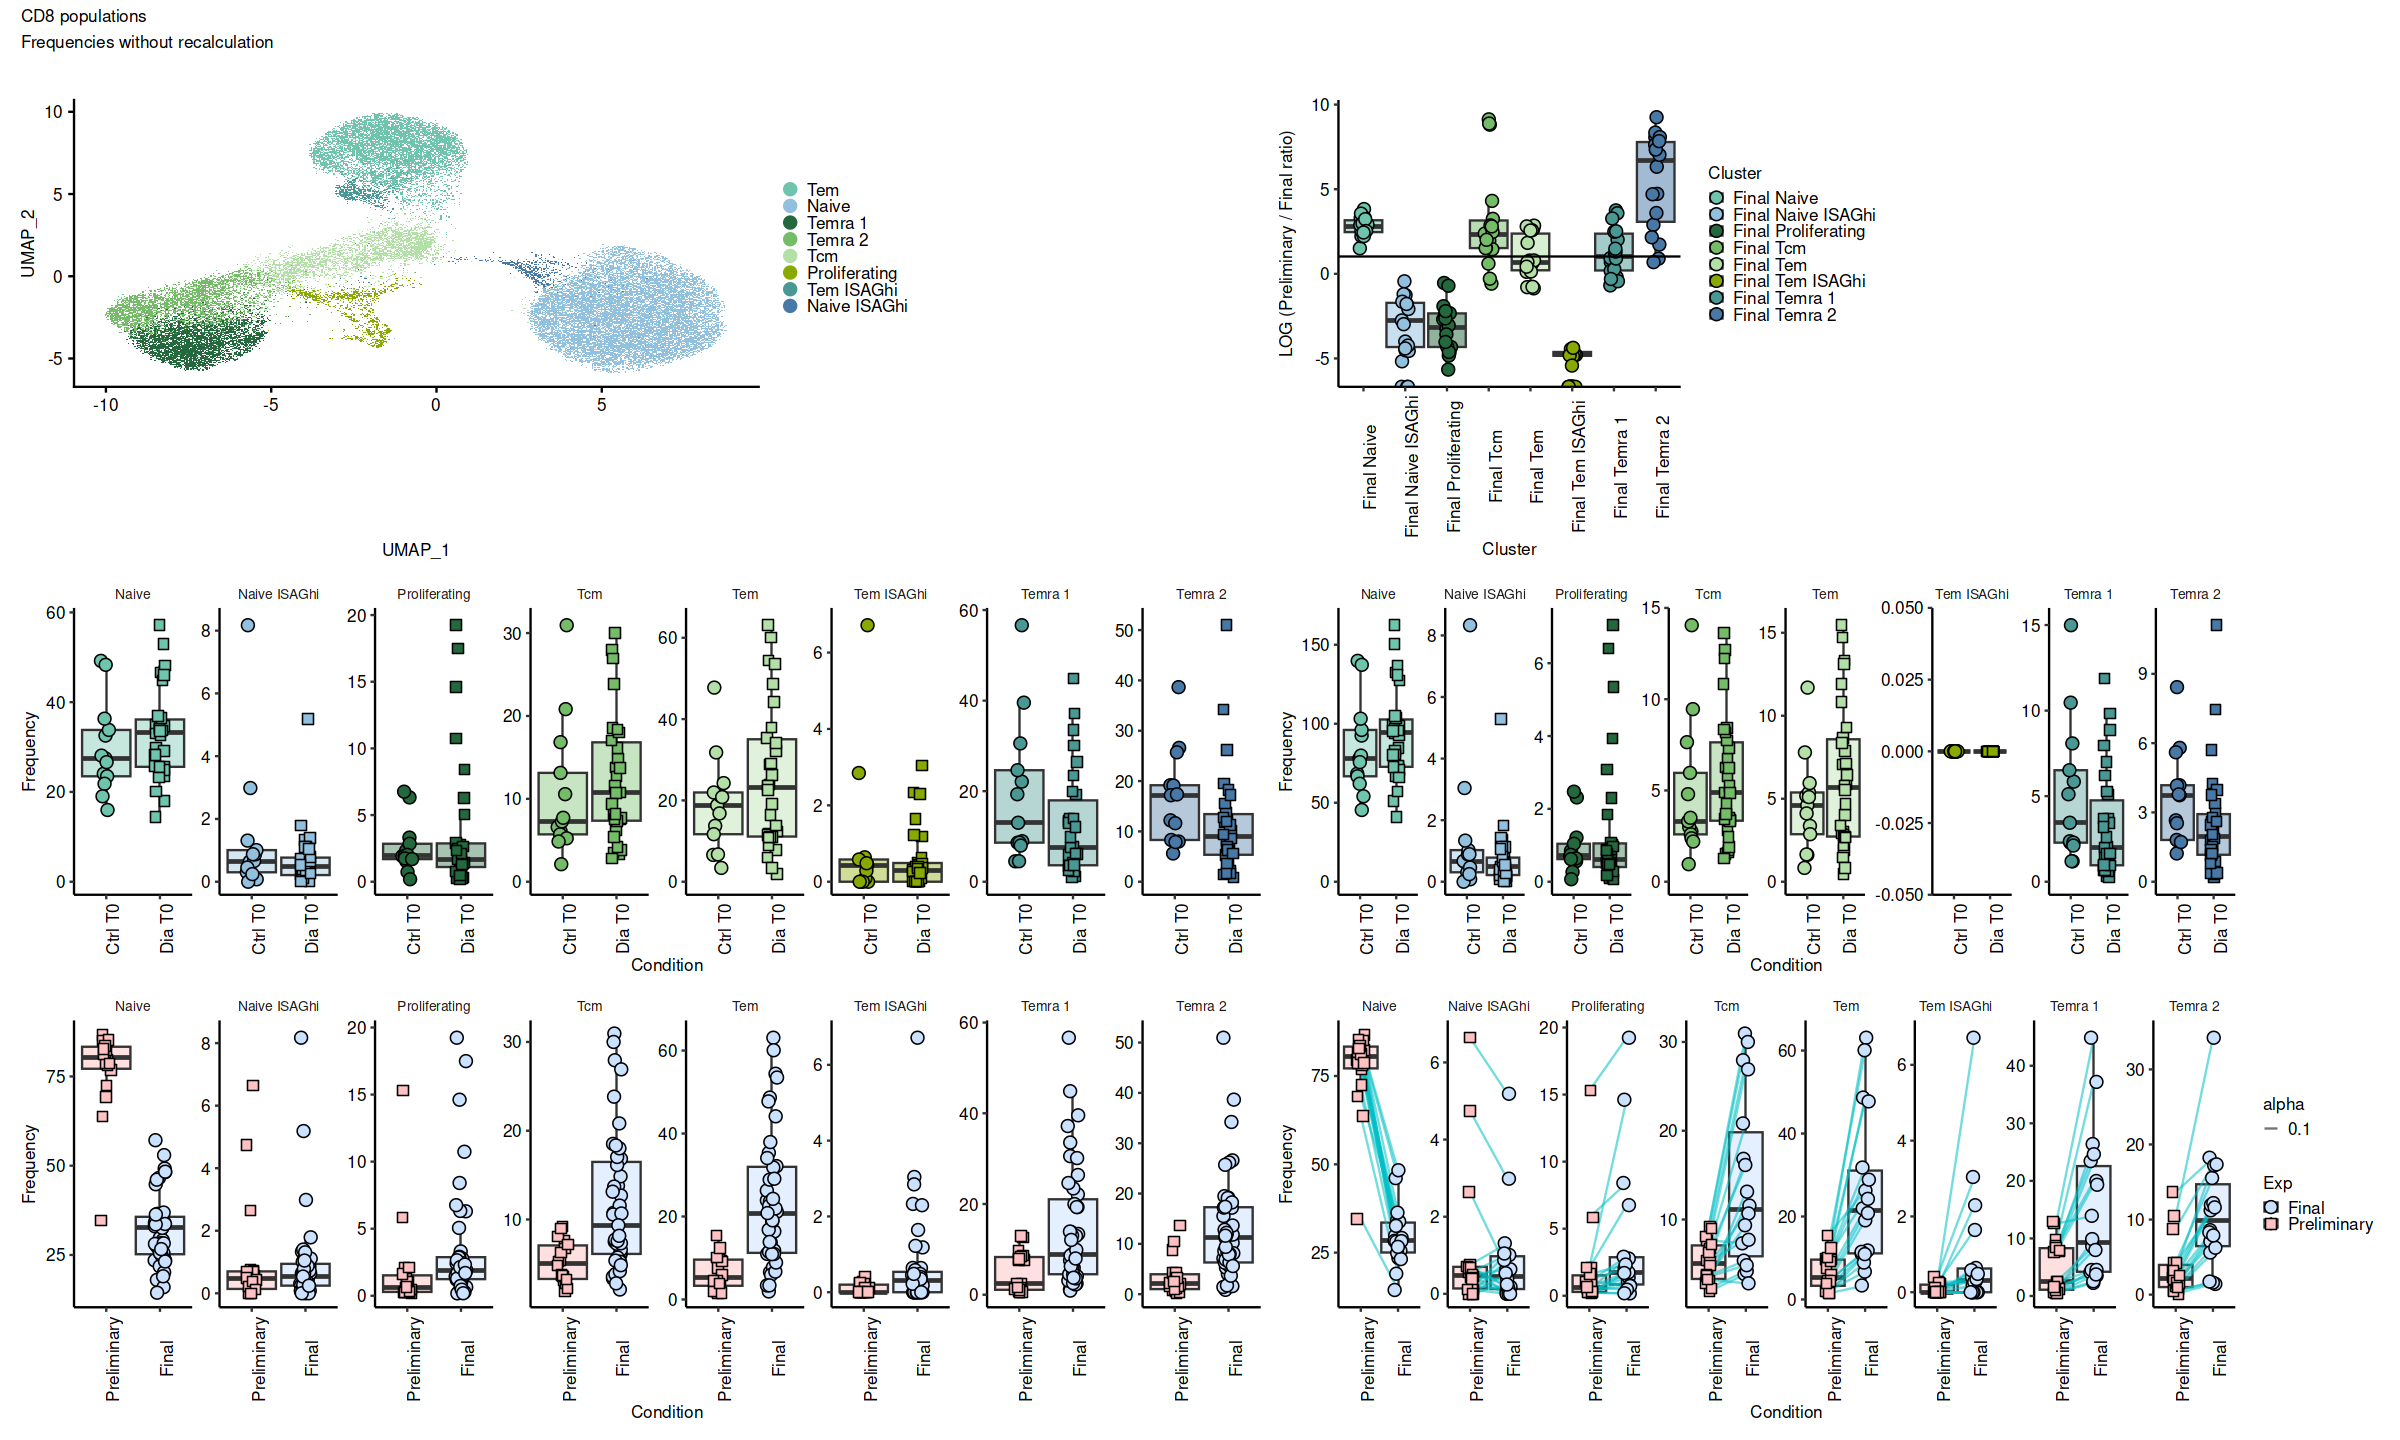

In [45]:
options(repr.plot.width = 20, repr.plot.height = 12)

layout <- "
AA#B#
CCCDD
EEEFF
"

p4 <- dimplot1 + plot_cluster_correction + p1 + p5 + p2 + plot_paired + plot_layout(design = layout) + 
plot_annotation(title = "CD8 populations",
                subtitle = "Frequencies without recalculation") & ggtheme()

p4

In [46]:
ggsave(filename="02_CD8subcluster_CD8.pdf", 
       plot = p3, 
       device = cairo_pdf, 
       width = 297, 
       height = 210, 
       units = "mm")

Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


### V2

sort ratios in these patients

In [179]:
cd8_subcluster@meta.data  %>% colnames

[1] "orig.ident"                           
  [2] "nCount_RNA"                           
  [3] "nFeature_RNA"                         
  [4] "percent.mt"                           
  [5] "percent.rp"                           
  [6] "nCount_Antibodies"                    
  [7] "nFeature_Antibodies"                  
  [8] "hashtags"                             
  [9] "Experiment_ID"                        
 [10] "Date_prepared"                        
 [11] "Prepared_by"                          
 [12] "Sample_ID"                            
 [13] "Well"                                 
 [14] "Hashtag"                              
 [15] "Hashtag_sequence"                     
 [16] "Hashtag_cat_n"                        
 [17] "Hashtag_dilution"                     
 [18] "Project.code"                         
 [19] "Well_CT_ID"                           
 [20] "Condition"                            
 [21] "Disease"                              
 [22] "Time"                                 
 [23] "Species"                              
 [24] "Age"                                  
 [25] "Age_group"                            
 [26] "Sex"                                  
 [27] "Library_code"                         
 [28] "Patient_ID"                           
 [29] "is_cell"                              
 [30] "chain"                                
 [31] "contig_id"                            
 [32] "high_confidence"                      
 [33] "productive"                           
 [34] "length"                               
 [35] "reads"                                
 [36] "umis"                                 
 [37] "vdj_source"                           
 [38] "count_TRA"                            
 [39] "count_TRB"                            
 [40] "count_Multi"                          
 [41] "cdr3_A1"                              
 [42] "cdr3_A1_nt"                           
 [43] "cdr3_A2"                              
 [44] "cdr3_A2_nt"                           
 [45] "cdr3_B"                               
 [46] "cdr3_B_nt"                            
 [47] "cdr3_Multi"                           
 [48] "cdr3_Multi_nt"                        
 [49] "v_gene_A1"                            
 [50] "j_gene_A1"                            
 [51] "v_gene_A2"                            
 [52] "j_gene_A2"                            
 [53] "v_gene_B"                             
 [54] "d_gene_B"                             
 [55] "j_gene_B"                             
 [56] "v_gene_Multi"                         
 [57] "d_gene_Multi"                         
 [58] "j_gene_Multi"                         
 [59] "clonotypes"                           
 [60] "has.VDJ"                              
 [61] "has.complete.VDJ"                     
 [62] "nCount_PTPRC"                         
 [63] "nFeature_PTPRC"                       
 [64] "RNA_snn_res.0.5"                      
 [65] "seurat_clusters"                      
 [66] "clonotype.repeated"                   
 [67] "RNA_snn_res.0.8"                      
 [68] "RNA_snn_res.1"                        
 [69] "barcode"                              
 [70] "Monaco_single"                        
 [71] "HPCA_single"                          
 [72] "Wherry_main"                          
 [73] "nCount_refAssay"                      
 [74] "nFeature_refAssay"                    
 [75] "predicted.celltype.l1.score"          
 [76] "predicted.celltype.l1"                
 [77] "predicted.celltype.l2.score"          
 [78] "predicted.celltype.l2"                
 [79] "predicted.celltype.l3.score"          
 [80] "predicted.celltype.l3"                
 [81] "mapping.score"                        
 [82] "RNA_snn_res.0.6"                      
 [83] "Sample_char"                          
 [84] "Patient_Time"                         
 [85] "patient"                              
 [86] "rc"                                   
 [87] "dat_nar"                              


Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


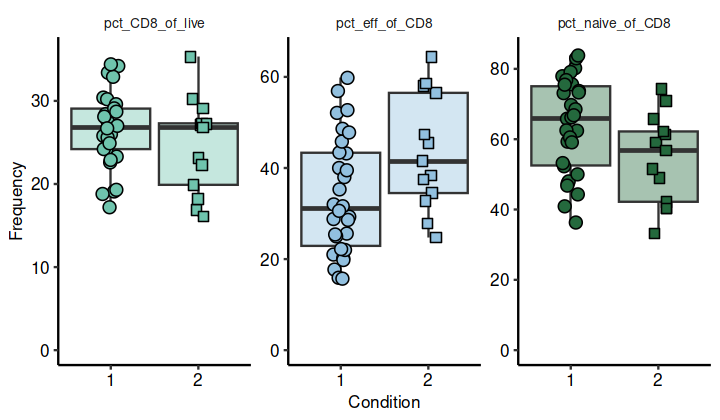

In [188]:
options(repr.plot.width = 6, repr.plot.height = 3.5)


cd8_subcluster@meta.data  %>% 
dplyr::select(Patient_ID, Patient_Time, Condition, Experiment_ID, pct_naive_of_CD8, pct_CD8_of_live, pct_eff_of_CD8)  %>% 
unique  %>%  
filter(Condition %in% c("Ctrl T0", "Dia T0") & Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"))  %>% 
dplyr::select(-Patient_Time, -Condition, -Experiment_ID)  %>% 
pivot_longer(!Patient_ID, names_to = "population", values_to = "freq")  %>% 
mutate(Condition = substr(Patient_ID,1,1))  %>% 
  ggplot(aes(x = Condition, y = freq)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = population)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = population, shape = Condition), color = "black") + 
  facet_wrap(~population, scales = "free", ncol = 13) +
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = cd8_subcluster@misc$cols_annotations_l2)+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 0)) + NoLegend()



### Identify clusters that were potentially sorted as naive vs. effector

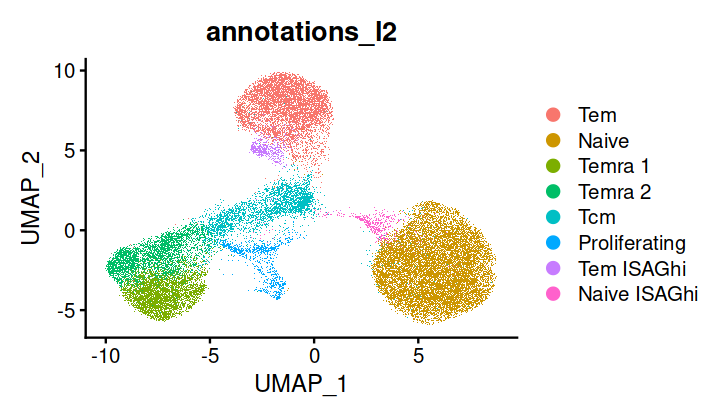

In [75]:
DimPlot(cd8_subcluster, raster = T, group.by = "annotations_l2")

Warning message:
"Could not find PTPRC-RA in the default search locations, found in PTPRC assay instead"


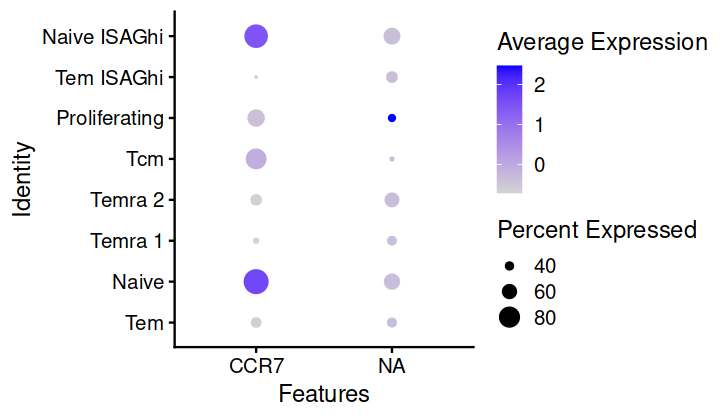

In [76]:
DotPlot(cd8_subcluster, features = c("CCR7","PTPRC-RA"), group.by = "annotations_l2")

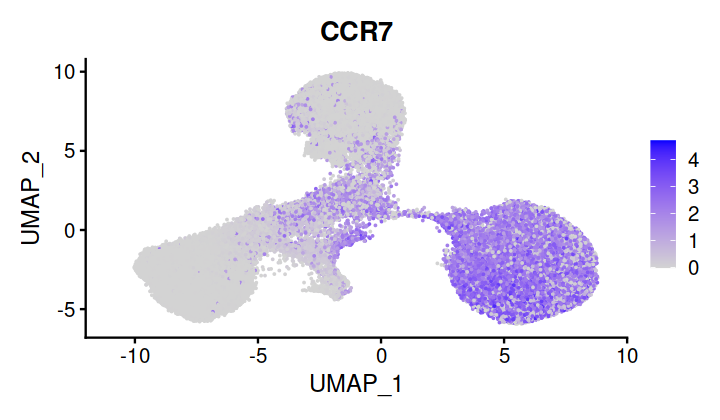

In [77]:
options(repr.plot.width = 6, repr.plot.height = 3.5)

FeaturePlot(cd8_subcluster, features = "CCR7", min.cutoff = 0)

Warning message:
"Could not find PTPRC-RO in the default search locations, found in PTPRC assay instead"


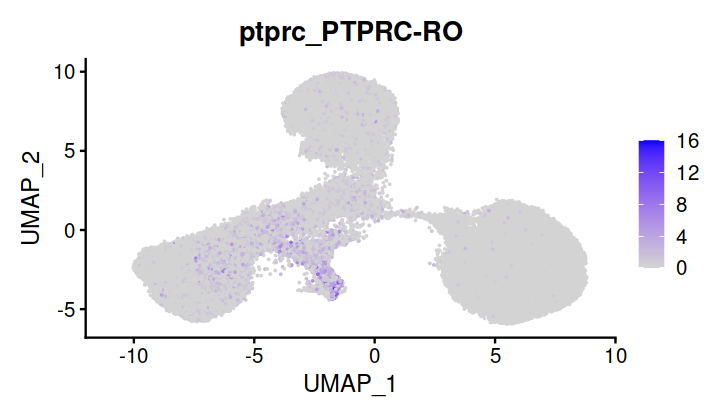

In [78]:
FeaturePlot(cd8_subcluster, features = "PTPRC-RO", min.cutoff = 0)

Warning message:
"Could not find PTPRC-RO in the default search locations, found in PTPRC assay instead"


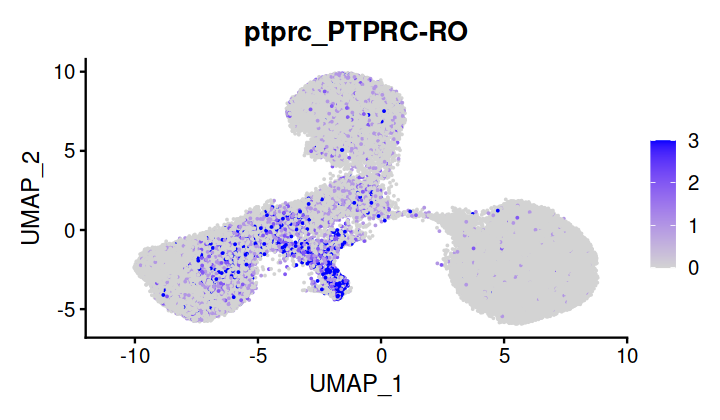

In [79]:
FeaturePlot(cd8_subcluster, features = "PTPRC-RO", min.cutoff = 0, max.cutoff = 3)

In [80]:
cd8_subcluster$naive_vs_eff  <- if_else(cd8_subcluster$annotations_l2 %in% c("Naive", "Naive ISAGhi"), "Naive", "Eff")

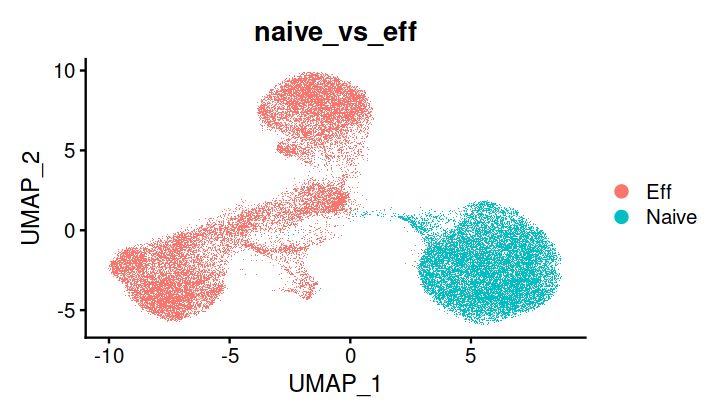

In [81]:
DimPlot(cd8_subcluster, raster = T, group.by = "naive_vs_eff")

In [82]:
cells_per_patient  <- cd8_subcluster@meta.data  %>% 
group_by(naive_vs_eff, Sample_ID, Patient_Time, pct_naive_of_CD8, pct_CD8_of_live, pct_eff_of_CD8)  %>% 
tally

In [83]:
cells_per_patient  <- cells_per_patient  %>% pivot_wider(names_from = "naive_vs_eff", values_from = "n", values_fill = 0)

In [84]:
cells_per_patient

Sample_ID,Patient_Time,pct_naive_of_CD8,pct_CD8_of_live,pct_eff_of_CD8,Eff,Naive
<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>
148,201 T0,61.3,18.2,37.5,144,581
149,202 T0,74.3,16.1,24.7,140,656
150,105 T0,83.8,34.2,15.7,116,784
151,110 T0,36.3,25.6,59.8,550,300
152,104 T0,59.3,27.0,40.0,131,757
153,106 T0,83.0,28.1,15.9,131,739
154,108 T0,46.8,28.4,52.1,182,571
155,111 T0,60.5,19.3,38.0,198,682
185,204 T0,62.2,23.1,34.5,93,527


In [85]:
cells_per_patient  <- cells_per_patient  %>% mutate(Eff_corrected = Eff*0.2*pct_eff_of_CD8,
                                                    Naive_corrected = Naive*pct_naive_of_CD8)

In [86]:
md6  <- cd8_subcluster@meta.data

In [87]:
md6  <- left_join(md6, cells_per_patient)

Joining with `by = join_by(Sample_ID, Patient_Time, pct_CD8_of_live,
pct_naive_of_CD8, pct_eff_of_CD8)`


In [88]:
md6  <- md6  %>% 
mutate(Exp = if_else(Experiment_ID %in% c("Exp16", "Exp18", "Exp19", "Exp20"), "Final", "Preliminary"))  %>% 
mutate(Eff_corrected = if_else(Exp == "Final",Eff_corrected,Eff),
       Naive_corrected = if_else(Exp == "Final",Naive_corrected,Naive)) %>% mutate(Naive_to_eff = Naive_corrected/Eff_corrected)

In [89]:
md6   %>% dplyr::select(Sample_ID, Experiment_ID, Patient_Time,pct_naive_of_CD8,pct_CD8_of_live,pct_eff_of_CD8,, Exp, Eff,Naive, Naive_corrected,Eff_corrected,Naive_to_eff)  %>% unique

,Sample_ID,Experiment_ID,Patient_Time,pct_naive_of_CD8,pct_CD8_of_live,pct_eff_of_CD8,Exp,Eff,Naive,Naive_corrected,Eff_corrected,Naive_to_eff
,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,150,Exp08,105 T0,83.8,34.2,15.7,Preliminary,116,784,784.0,116.00,6.7586207
2,148,Exp08,201 T0,61.3,18.2,37.5,Preliminary,144,581,581.0,144.00,4.0347222
3,153,Exp08,106 T0,83.0,28.1,15.9,Preliminary,131,739,739.0,131.00,5.6412214
4,152,Exp08,104 T0,59.3,27.0,40.0,Preliminary,131,757,757.0,131.00,5.7786260
6,154,Exp08,108 T0,46.8,28.4,52.1,Preliminary,182,571,571.0,182.00,3.1373626
7,149,Exp08,202 T0,74.3,16.1,24.7,Preliminary,140,656,656.0,140.00,4.6857143
15,155,Exp08,111 T0,60.5,19.3,38.0,Preliminary,198,682,682.0,198.00,3.4444444
22,151,Exp08,110 T0,36.3,25.6,59.8,Preliminary,550,300,300.0,550.00,0.5454545
6663,185,Exp10,204 T0,62.2,23.1,34.5,Preliminary,93,527,527.0,93.00,5.6666667


Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


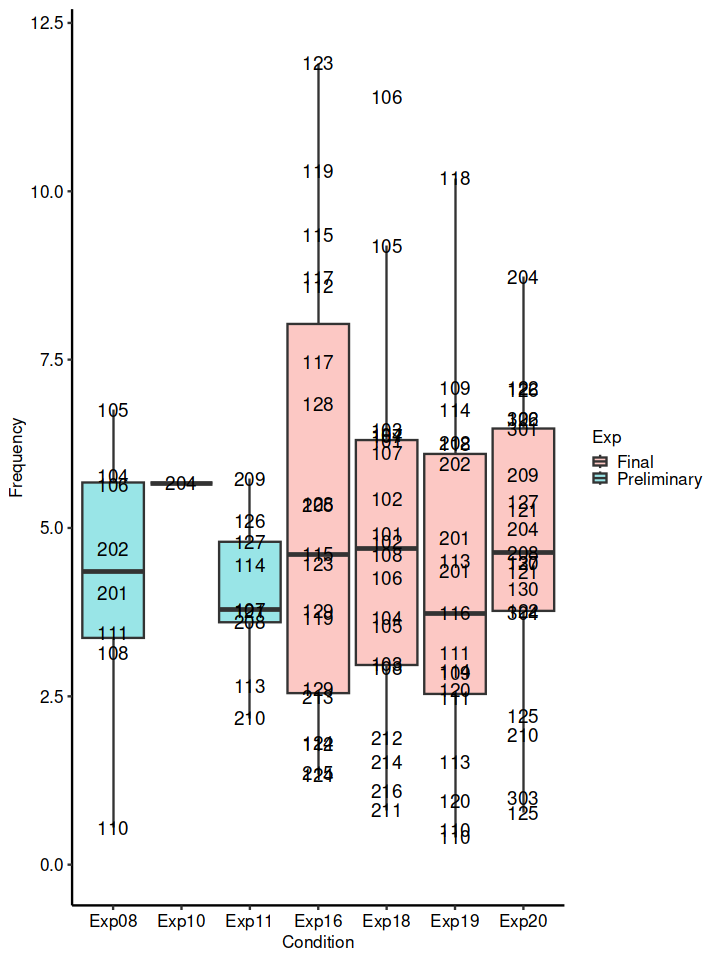

In [95]:
options(repr.plot.width = 6, repr.plot.height = 8)

md6   %>% 
dplyr::select(Sample_ID, Experiment_ID, Exp, Naive_to_eff, Patient_ID)  %>% unique  %>% 
ggplot(aes(x = Experiment_ID, y = Naive_to_eff)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
   geom_text(aes(label = Patient_ID)) + 
scale_shape_manual(values = c(21,22))+
  ylab("Frequency") +
  xlab("Condition") +
  theme_classic() +
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 0)) 

Warning message in geom_jitter(binaxis = "y", position = position_jitter(width = 0.1, :
"Ignoring unknown parameters: `binaxis` and `stackdir`"
Bin width defaults to 1/30 of the range of the data. Pick better value with
`binwidth`.


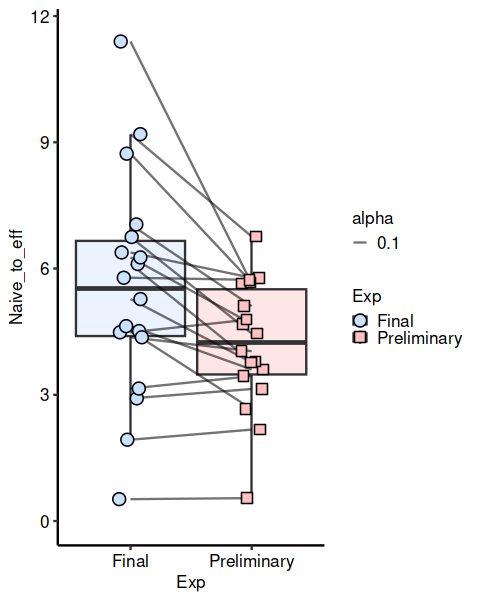

In [98]:
options(repr.plot.width = 4, repr.plot.height = 5)

md6   %>% 
filter(Condition %in% c("Ctrl T0", "Dia T0") & Patient_ID %in% patients_with_preliminary)  %>% 
dplyr::select(Sample_ID, Patient_ID, Experiment_ID, Exp, Naive_to_eff)  %>% unique  %>% 
ggplot(aes(x = Exp, y = Naive_to_eff)) + # you can change the x to whatever variable you're interested in
  geom_boxplot(outlier.shape = NA, 
           alpha = 0.4, width = 0.9, aes(fill = Exp)) +
   geom_dotplot(binaxis='y', stackdir='center', dotsize=0) + 
     geom_line(aes(group = Patient_ID, alpha = 0.1)) +
   geom_jitter(binaxis='y', position=position_jitter(width = 0.1, height = 0), 
  size = 3, stackdir='center', aes(fill = Exp, shape = Exp), color = "black") + 
scale_shape_manual(values = c(21,22))+
scale_fill_manual(values = c("lightsteelblue1","rosybrown1"))+
  theme_classic() +
ggtheme() +
 ylim(0,NA) +
theme(strip.background = element_blank(), panel.grid = element_blank()) + 
  theme(axis.text = element_text(color = "black"),
        axis.line = element_line(color = "black"),
        axis.text.x = element_text(angle = 0)) 
